In [1]:
!python --version

Python 3.9.17


In [2]:
!pip install pydub

You should consider upgrading via the '/home/arif/anaconda3/envs/coqui/bin/python -m pip install --upgrade pip' command.


## Import Statements

In [10]:
%matplotlib inline
from pydub import AudioSegment
from pydub.playback import play
import IPython.display as ipd
import os
import re
import shutil
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path

# Analyzing VCTK Dataset

Accoring to `Coqui TTS dataset formatter`, our version is `vctk_old`. 

URL:
    homepages.inf.ed.ac.uk/jyamagis/release/VCTK-Corpus.tar.gz

**New `vctk` corpus information:**

VCTK dataset v0.92.

URL:
    https://datashare.ed.ac.uk/bitstream/handle/10283/3443/VCTK-Corpus-0.92.zip

This dataset has 2 recordings per speaker that are annotated with ```mic1``` and ```mic2```.
It is believed that (😄 ) ```mic1``` files are the same as the previous version of the dataset.

mic1:
    Audio recorded using an omni-directional microphone (DPA 4035).
    Contains very low frequency noises.
    This is the same audio released in previous versions of VCTK:
    https://doi.org/10.7488/ds/1994

mic2:
    Audio recorded using a small diaphragm condenser microphone with
    very wide bandwidth (Sennheiser MKH 800).
    Two speakers, p280 and p315 had technical issues of the audio
    recordings using MKH 800.

In [6]:
# vctk_old formatter from Coqui
def vctk_old(root_path, meta_files=None, wavs_path="wav48", ignored_speakers=None):
    """homepages.inf.ed.ac.uk/jyamagis/release/VCTK-Corpus.tar.gz"""
    items = []
    meta_files = glob(f"{os.path.join(root_path,'txt')}/**/*.txt", recursive=True)
    for meta_file in meta_files:
        _, speaker_id, txt_file = os.path.relpath(meta_file, root_path).split(os.sep)
        file_id = txt_file.split(".")[0]
        # ignore speakers
        if isinstance(ignored_speakers, list):
            if speaker_id in ignored_speakers:
                continue
        with open(meta_file, "r", encoding="utf-8") as file_text:
            text = file_text.readlines()[0]
        wav_file = os.path.join(root_path, wavs_path, speaker_id, file_id + ".wav")
        items.append(
            {"text": text, "audio_file": wav_file, "speaker_name": "VCTK_old_" + speaker_id, "root_path": root_path}
        )
    return items

In [7]:
root_path="/media/arif/New Volume/Etc/data/VCTK/archive/VCTK-Corpus/VCTK-Corpus"

In [11]:
items = vctk_old(root_path)

In [13]:
counter = 0
for item in items:
    print(item)
    counter += 1
    if counter == 5: break

{'text': 'Please call Stella.\n', 'audio_file': '/media/arif/New Volume/Etc/data/VCTK/archive/VCTK-Corpus/VCTK-Corpus/wav48/p225/p225_001.wav', 'speaker_name': 'VCTK_old_p225', 'root_path': '/media/arif/New Volume/Etc/data/VCTK/archive/VCTK-Corpus/VCTK-Corpus'}
{'text': 'Ask her to bring these things with her from the store.\n', 'audio_file': '/media/arif/New Volume/Etc/data/VCTK/archive/VCTK-Corpus/VCTK-Corpus/wav48/p225/p225_002.wav', 'speaker_name': 'VCTK_old_p225', 'root_path': '/media/arif/New Volume/Etc/data/VCTK/archive/VCTK-Corpus/VCTK-Corpus'}
{'text': 'Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.\n', 'audio_file': '/media/arif/New Volume/Etc/data/VCTK/archive/VCTK-Corpus/VCTK-Corpus/wav48/p225/p225_003.wav', 'speaker_name': 'VCTK_old_p225', 'root_path': '/media/arif/New Volume/Etc/data/VCTK/archive/VCTK-Corpus/VCTK-Corpus'}
{'text': 'We also need a small plastic snake and a big toy frog for the kids.\n', 'audio_file': 

In [3]:
### X 
word_freq = {}
max_words = 0
min_words = 500
total_words = 0

csvfile = '/media/arif/Resource/Etc/data/LJSpeech-1.1/metadata.csv' # lab
csvfile = '/mnt/resource/Etc/data/LJSpeech-1.1/metadata.csv'        # home
with open(csvfile) as f:
    for i, line in enumerate(f):
        text = line.split('|')[2].strip()
        text = text.replace('.', ' ').replace(',', ' ').replace(';', ' ').replace('?', ' ').replace('!', ' ').replace('"', ' ')

        n = len(text.split())
        if n in word_freq: 
            word_freq[n] += 1
        else:
            word_freq[n] = 1
        max_words = max(max_words, n)
        min_words = min(min_words, n)
        total_words += n

        #if i == 50: break
print(f'Maximum words in a sentence: {max_words}')
print(f'Minimum words in a sentence: {min_words}')
print(f'Average words per sentence: {total_words / (i+1): .2f}')

Maximum words in a sentence: 39
Minimum words in a sentence: 1
Average words per sentence:  17.01


Text(0, 0.5, 'No. of samples')

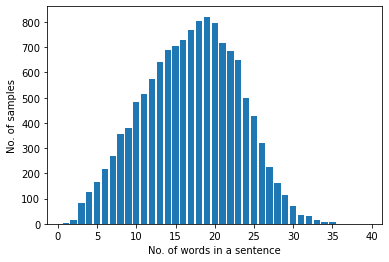

In [5]:
### X
plt.bar(word_freq.keys(), word_freq.values())
plt.xlabel('No. of words in a sentence')
plt.ylabel('No. of samples')

## Duration Calculation 
Calculating duration of original `vctk_old` 

**Summary:**
```
Total duration: 44 hours 2.36 minutes
Maximum duration: 19.28 seconds
Minimum duration: 0.60 seconds
Average duration: 3.58 seconds
```

In [16]:
wavdir = "/media/arif/New Volume/Etc/data/VCTK/archive/VCTK-Corpus/VCTK-Corpus/wav48"

wav_files = glob(f"{wavdir}/**/*.wav", recursive=True)

wav_duration = {}
max_duration = 0
min_duration = 1000
total_duration = 0

for i, file in enumerate(wav_files):
    audio = AudioSegment.from_wav(file)

    duration = audio.duration_seconds

    max_duration = max(max_duration, duration)
    min_duration = min(min_duration, duration)
    total_duration += duration

    duration = int(duration)
    if duration in wav_duration:
        wav_duration[duration] += 1
    else:
        wav_duration[duration] = 1

    # if i == 5: break

avg_duration = total_duration / len(wav_files)
total_duration /= 60 # sec. to min.
duration_hours = total_duration // 60
duration_mins = total_duration - (duration_hours * 60)

print(f"Total duration: {int(duration_hours)} hours {duration_mins:.2f} minutes")
print(f'Maximum duration: {max_duration:.2f} seconds')
print(f'Minimum duration: {min_duration:.2f} seconds')
print(f'Average duration: {avg_duration:.2f} seconds')

Total duration: 44 hours 2.36 minutes
Maximum duration: 19.28 seconds
Minimum duration: 0.60 seconds
Average duration: 3.58 seconds


## Creating LJ-mini corpus

* corpus will contain about 8 hours of speech
* word length: 3-30

In [2]:
wavdir = '/media/arif/Resource/Etc/data/LJSpeech-1.1/wavs'
wavdir = '/mnt/resource/Etc/data/LJSpeech-1.1/wavs'
destdir = '/media/arif/Resource/Etc/data/lj-mini/wavs'
destdir = '/mnt/resource/Etc/data/lj-mini/wavs'

with open('/mnt/resource/Etc/data/LJSpeech-1.1/metadata.csv') as f:
    with open('/mnt/resource/Etc/data/lj-mini/mini-metadata.csv', 'w') as outfile:
        duration = 0
        for i, line in enumerate(f):
            idx, txt, normtxt = line.split('|')

            normtxt = normtxt.replace('.', ' ').replace(',', ' ').replace(';', ' ').replace('?', ' ').replace('!', ' ').replace('"', ' ')
            nwords = len(normtxt.split())

            if nwords < 3 or nwords > 30:
                print(idx)
                continue

            outfile.write(line)
            
            wavpath = os.path.join(wavdir, idx+'.wav')
            shutil.copy(wavpath, destdir)

            audio = AudioSegment.from_wav(wavpath)
            duration += audio.duration_seconds
            if duration >= 28800: # 8 hours
                break

            #if i == 5: break

LJ001-0014
LJ001-0152
LJ003-0011
LJ005-0223
LJ007-0060
LJ007-0229
LJ008-0263
LJ009-0053
LJ009-0129
LJ011-0101
LJ011-0154
LJ012-0116
LJ012-0147
LJ014-0079
LJ014-0133


In [13]:
ljwavdir = '/media/arif/Resource/Etc/data/lj-mini/wavs'

files = os.listdir(ljwavdir)

wav_duration = {}
max_duration = 0
min_duration = 1000
total_duration = 0

for i, file in enumerate(files):
    audio = AudioSegment.from_wav(os.path.join(ljwavdir, file))

    duration = audio.duration_seconds

    max_duration = max(max_duration, duration)
    min_duration = min(min_duration, duration)
    total_duration += duration

    duration = int(duration)
    if duration in wav_duration:
        wav_duration[duration] += 1
    else:
        wav_duration[duration] = 1

    #if i == 5: break

avg_duration = total_duration / len(files)
total_duration /= 60 # sec. to min.
duration_hours = total_duration // 60
duration_mins = total_duration - (duration_hours * 60)

print("LJ-mini corpus info:")
print(f"Total duration: {int(duration_hours)} hours {duration_mins:.2f} minutes")
print(f'Maximum duration: {max_duration:.2f} seconds')
print(f'Minimum duration: {min_duration:.2f} seconds')
print(f'Average duration: {avg_duration:.2f} seconds')

LJ-mini corpus info:
Total duration: 8 hours 0.00 minutes
Maximum duration: 10.10 seconds
Minimum duration: 1.12 seconds
Average duration: 6.61 seconds
